# Notebook 06: creditcard Threshold Optimization & Test Evaluation

**Dataset**: creditcard.csv (Real-World ULB)

**Objective**: Final threshold tuning on validation set and ONE-TIME test evaluation

**Primary Metric**: PR-AUC (optimal for extreme imbalance)

**⚠️ CRITICAL CONSTRAINT**: Test set evaluation performed EXACTLY ONCE to prevent overfitting

**Workflow**:
1. Load best NN model from Notebook 05 (by validation PR-AUC)
2. Threshold optimization on validation set
3. **Final test set evaluation** (single evaluation)
4. Error analysis (FP/FN patterns)
5. Business cost simulation
6. Final model recommendations

In [9]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import joblib
import sys
import os
import json
from pathlib import Path
import importlib

# Add src to path
sys.path.append(os.path.abspath('../'))

# Import and reload modules
import config
import src.nn_architectures
import src.nn_training_utils
import src.evaluation_metrics
import src.visualization_utils

importlib.reload(config)
importlib.reload(src.nn_architectures)
importlib.reload(src.nn_training_utils)
importlib.reload(src.evaluation_metrics)
importlib.reload(src.visualization_utils)

from src.evaluation_metrics import compute_fraud_metrics, print_classification_summary
from src.visualization_utils import (
    plot_confusion_matrix,
    plot_precision_recall_curve
)

# Set random seeds
config.set_random_seeds()

# Get dataset config
ds_config = config.get_dataset_config('creditcard')

print("✓ Imports complete")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ Random seed set to {config.RANDOM_SEED}")
print(f"✓ Dataset: creditcard.csv (Real-World ULB)")

✓ Imports complete
✓ TensorFlow version: 2.15.0
✓ Random seed set to 42
✓ Dataset: creditcard.csv (Real-World ULB)


## 1. Load Preprocessed Data

In [10]:
# Load original data
df = pd.read_csv(ds_config['data_path'])
X = df[ds_config['feature_cols']].values
y = df[ds_config['target_col']].values

# Load saved split indices
train_idx = np.load(ds_config['train_idx'])
val_idx = np.load(ds_config['val_idx'])
test_idx = np.load(ds_config['test_idx'])

# Split data using saved indices
X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]
X_test, y_test = X[test_idx], y[test_idx]

# Load fitted scaler
scaler = joblib.load(ds_config['scaler_path'])

# Transform data
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("✓ Data loaded and preprocessed:")
print(f"  Train: {X_train_scaled.shape[0]:,} samples")
print(f"  Val:   {X_val_scaled.shape[0]:,} samples")
print(f"  Test:  {X_test_scaled.shape[0]:,} samples")
print(f"  Features: {X_train_scaled.shape[1]}")
print(f"\n✓ Class distribution:")
print(f"  Train fraud rate: {y_train.mean()*100:.4f}%")
print(f"  Val fraud rate:   {y_val.mean()*100:.4f}%")
print(f"  Test fraud rate:  {y_test.mean()*100:.4f}%")

✓ Data loaded and preprocessed:
  Train: 199,364 samples
  Val:   42,721 samples
  Test:  42,722 samples
  Features: 30

✓ Class distribution:
  Train fraud rate: 0.1725%
  Val fraud rate:   0.1732%
  Test fraud rate:  0.1732%


## 2. Load Best Model from Notebook 05

In [11]:
# Load experiment logs from Notebook 05
nn_experiments_log = ds_config['experiment_logs_dir'] / 'nn_experiments.csv'

if nn_experiments_log.exists():
    experiments_df = pd.read_csv(nn_experiments_log)
    
    # Filter for creditcard experiments
    creditcard_experiments = experiments_df[experiments_df['dataset'] == 'creditcard']
    
    # Sort by validation PR-AUC
    creditcard_experiments = creditcard_experiments.sort_values('pr_auc', ascending=False)
    
    print("\n" + "="*80)
    print(" TOP 5 MODELS BY VALIDATION PR-AUC")
    print("="*80)
    print(creditcard_experiments[['experiment_id', 'experiment_type', 'pr_auc', 'f1_fraud', 'recall_fraud']].head().to_string(index=False))
    print("="*80)
    
    # Get best experiment
    best_exp = creditcard_experiments.iloc[0]
    best_exp_id = best_exp['experiment_id']
    
    print(f"\n🏆 Best Model: {best_exp_id}")
    print(f"   Type: {best_exp['experiment_type']}")
    print(f"   Validation PR-AUC: {best_exp['pr_auc']:.4f}")
    print(f"   Validation F1 (Fraud): {best_exp['f1_fraud']:.4f}")
    print(f"   Validation Recall (Fraud): {best_exp['recall_fraud']:.4f}")
    
else:
    print("⚠️ No experiment logs found. Please run Notebook 05 first.")
    best_exp_id = None


 TOP 5 MODELS BY VALIDATION PR-AUC
experiment_id experiment_type   pr_auc  f1_fraud  recall_fraud
       REG-07  regularization 0.780227  0.628866      0.824324
       REG-05  regularization 0.750452  0.434164      0.824324
       REG-01  regularization 0.728132  0.567164      0.770270
       REG-02  regularization 0.727281  0.448669      0.797297
       REG-08  regularization 0.650958  0.312020      0.824324

🏆 Best Model: REG-07
   Type: regularization
   Validation PR-AUC: 0.7802
   Validation F1 (Fraud): 0.6289
   Validation Recall (Fraud): 0.8243


In [13]:
# Load the best model
best_model = None

if best_exp_id:
    # Try different possible model paths
    possible_paths = [
        ds_config['models_dir'] / 'neural_networks' / f'{best_exp_id}.keras',
        ds_config['models_dir'] / 'neural_networks' / f'{best_exp_id}_{best_exp["model_name"]}.keras',
        ds_config['models_dir'] / 'neural_networks' / f'{best_exp_id}_{best_exp["experiment_type"]}.keras',
    ]
    
    for model_path in possible_paths:
        if model_path.exists():
            best_model = keras.models.load_model(model_path)
            print(f"\n✓ Model loaded from: {model_path}")
            break
    
    if best_model is None:
        print(f"\n⚠️ Model file not found. Searched paths:")
        for p in possible_paths:
            print(f"   - {p}")
else:
    print("\n⚠️ No best model identified. Please run Notebook 05 first.")



✓ Model loaded from: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\models\neural_networks\REG-07_regularization.keras


## 3. Threshold Optimization on Validation Set

Test multiple thresholds to find optimal balance between precision and recall.

In [14]:
# Get validation predictions (probabilities)
y_val_pred_proba = best_model.predict(X_val_scaled, verbose=0).flatten()

# Test threshold candidates
threshold_results = []

for threshold in config.THRESHOLD_CANDIDATES:
    y_val_pred = (y_val_pred_proba >= threshold).astype(int)
    metrics = compute_fraud_metrics(y_val, y_val_pred, y_val_pred_proba)
    
    threshold_results.append({
        'threshold': threshold,
        'precision_fraud': metrics['precision_fraud'],
        'recall_fraud': metrics['recall_fraud'],
        'f1_fraud': metrics['f1_fraud'],
        'pr_auc': metrics['pr_auc']
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_results)

print("\n" + "="*90)
print(" THRESHOLD OPTIMIZATION RESULTS (Validation Set)")
print("="*90)
print(threshold_df.to_string(index=False))
print("="*90)

# Find best threshold by F1
best_threshold_idx = threshold_df['f1_fraud'].idxmax()
best_threshold = threshold_df.loc[best_threshold_idx, 'threshold']
best_f1 = threshold_df.loc[best_threshold_idx, 'f1_fraud']

print(f"\n🎯 Optimal Threshold: {best_threshold}")
print(f"   F1 (Fraud): {best_f1:.4f}")
print(f"   Precision (Fraud): {threshold_df.loc[best_threshold_idx, 'precision_fraud']:.4f}")
print(f"   Recall (Fraud): {threshold_df.loc[best_threshold_idx, 'recall_fraud']:.4f}")

# Save threshold results
threshold_path = ds_config['tables_dir'] / 'threshold_optimization.csv'
threshold_df.to_csv(threshold_path, index=False)
print(f"\n✓ Threshold results saved to: {threshold_path}")


 THRESHOLD OPTIMIZATION RESULTS (Validation Set)
 threshold  precision_fraud  recall_fraud  f1_fraud   pr_auc
      0.10         0.261803      0.824324  0.397394 0.780227
      0.15         0.322751      0.824324  0.463878 0.780227
      0.20         0.358824      0.824324  0.500000 0.780227
      0.25         0.388535      0.824324  0.528139 0.780227
      0.30         0.426573      0.824324  0.562212 0.780227
      0.35         0.442029      0.824324  0.575472 0.780227
      0.40         0.469231      0.824324  0.598039 0.780227
      0.45         0.484127      0.824324  0.610000 0.780227
      0.50         0.508333      0.824324  0.628866 0.780227
      0.55         0.521368      0.824324  0.638743 0.780227
      0.60         0.555556      0.810811  0.659341 0.780227

🎯 Optimal Threshold: 0.6
   F1 (Fraud): 0.6593
   Precision (Fraud): 0.5556
   Recall (Fraud): 0.8108

✓ Threshold results saved to: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\tables\threshold_optimizati

## 4. Visualize Precision-Recall Tradeoff

✓ Figure saved to: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\figures\threshold_optimization.png


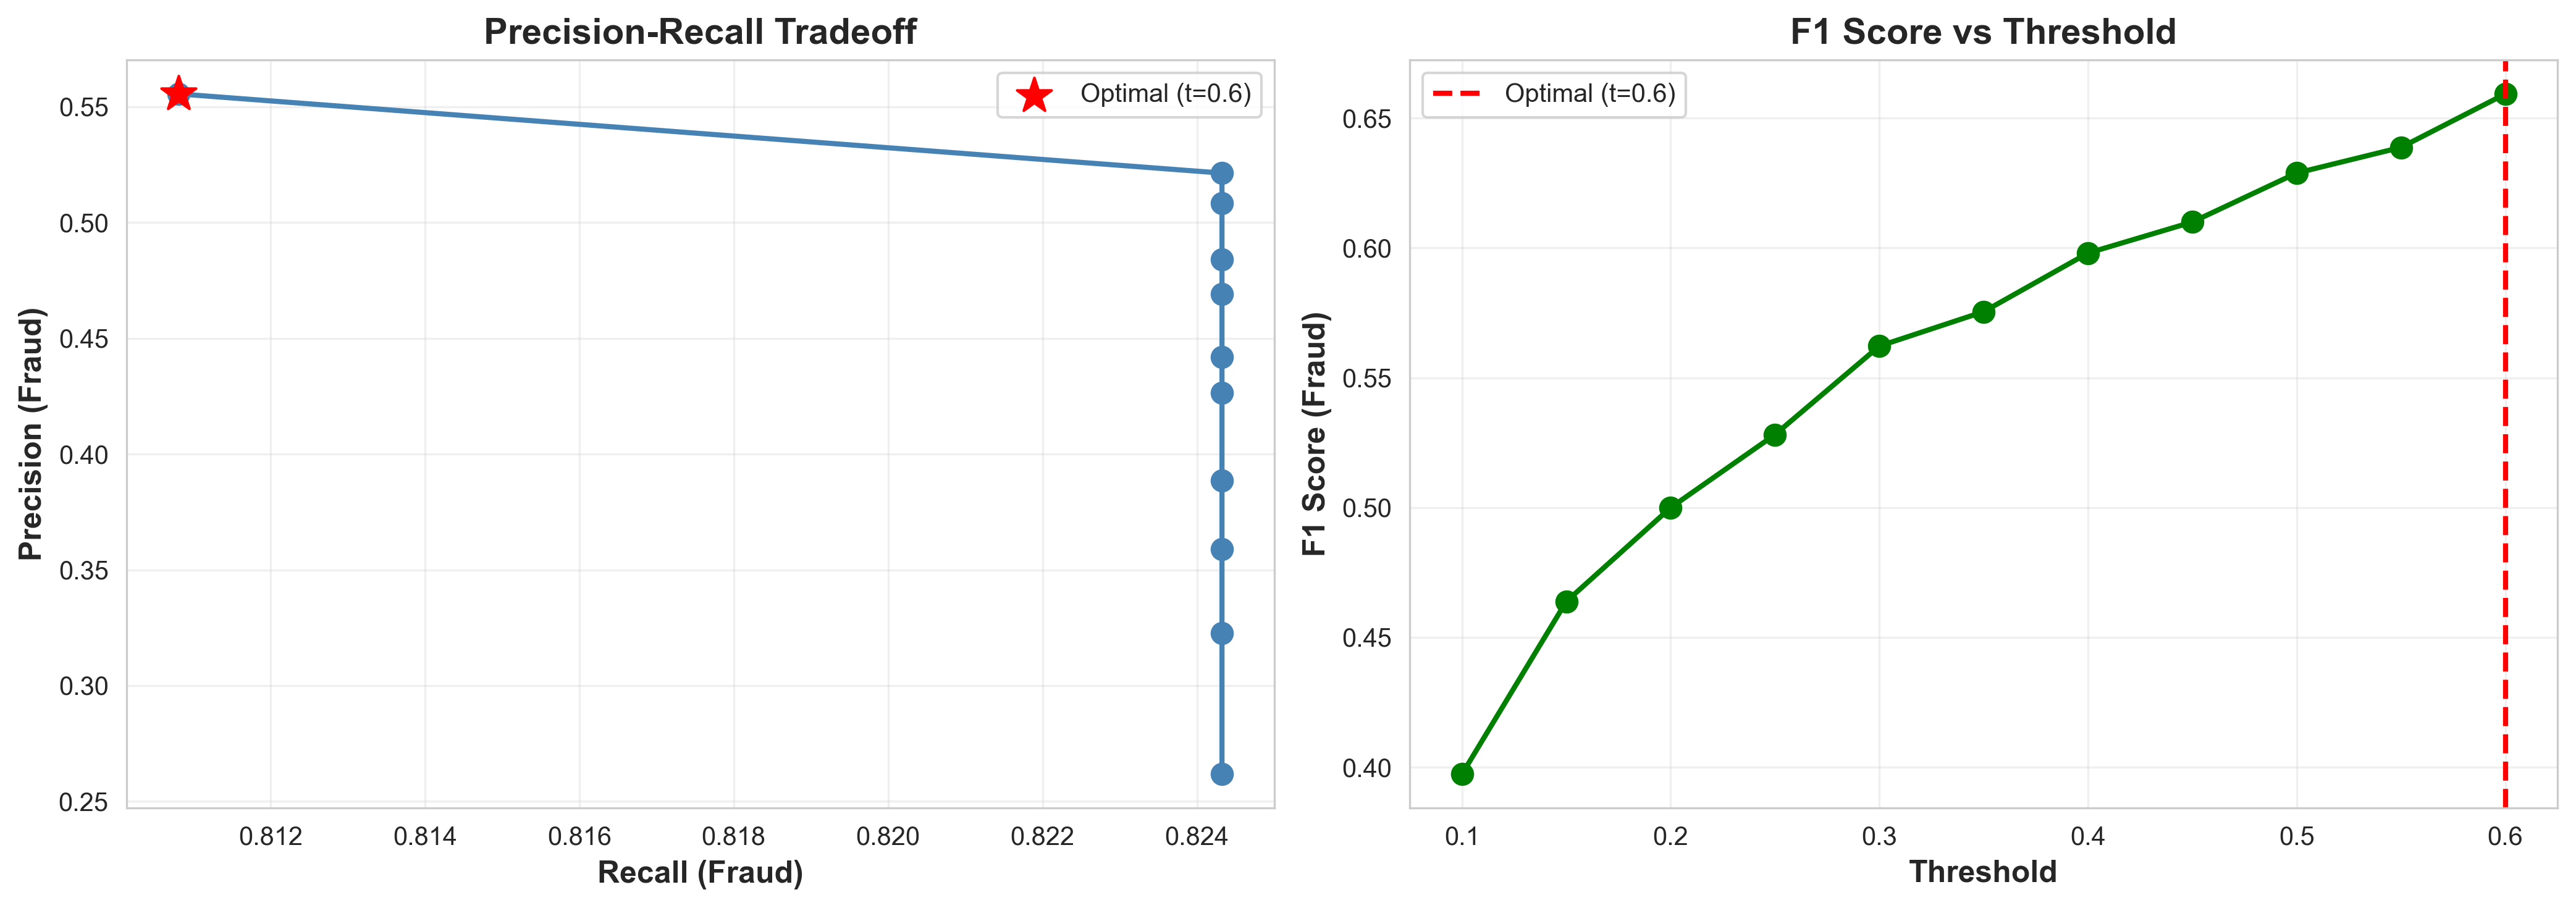

In [15]:
# Plot threshold optimization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision vs Recall
axes[0].plot(threshold_df['recall_fraud'], threshold_df['precision_fraud'], 
             marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].scatter(threshold_df.loc[best_threshold_idx, 'recall_fraud'],
                threshold_df.loc[best_threshold_idx, 'precision_fraud'],
                color='red', s=200, marker='*', zorder=5, label=f'Optimal (t={best_threshold})')
axes[0].set_xlabel('Recall (Fraud)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Precision (Fraud)', fontsize=12, fontweight='bold')
axes[0].set_title('Precision-Recall Tradeoff', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Plot 2: F1 vs Threshold
axes[1].plot(threshold_df['threshold'], threshold_df['f1_fraud'], 
             marker='o', linewidth=2, markersize=8, color='green')
axes[1].axvline(best_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal (t={best_threshold})')
axes[1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1].set_ylabel('F1 Score (Fraud)', fontsize=12, fontweight='bold')
axes[1].set_title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

plt.tight_layout()
fig_path = ds_config['figures_dir'] / 'threshold_optimization.png'
fig_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
plt.savefig(fig_path, dpi=config.FIGURE_DPI, bbox_inches='tight')
print(f"✓ Figure saved to: {fig_path}")
plt.show()

## 5. ⚠️ FINAL TEST SET EVALUATION (ONE-TIME ONLY)

**CRITICAL**: This is the ONLY evaluation on the test set. No iteration allowed.

In [17]:
print("\n" + "="*80)
print(" ⚠️  FINAL TEST SET EVALUATION - ONE-TIME ONLY")
print("="*80)
print("\nEvaluating on held-out test set with optimal threshold...\n")

# Get test predictions
y_test_pred_proba = best_model.predict(X_test_scaled, verbose=0).flatten()
y_test_pred = (y_test_pred_proba >= best_threshold).astype(int)

# Compute test metrics
test_metrics = compute_fraud_metrics(y_test, y_test_pred, y_test_pred_proba)

print("\n" + "="*80)
print(" FINAL TEST SET PERFORMANCE")
print("="*80)
print(f"\nModel: {best_exp_id}")
print(f"Threshold: {best_threshold}")
print(f"\nMetrics:")
print(f"  PR-AUC:             {test_metrics['pr_auc']:.4f}")
print(f"  ROC-AUC:            {test_metrics['roc_auc']:.4f}")
print(f"  F1 (Fraud):         {test_metrics['f1_fraud']:.4f}")
print(f"  Recall (Fraud):     {test_metrics['recall_fraud']:.4f}")
print(f"  Precision (Fraud):  {test_metrics['precision_fraud']:.4f}")
print(f"  Accuracy:           {test_metrics['accuracy']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {test_metrics['true_negatives']:,}")
print(f"  False Positives: {test_metrics['false_positives']:,}")
print(f"  False Negatives: {test_metrics['false_negatives']:,}")
print(f"  True Positives:  {test_metrics['true_positives']:,}")
print("="*80)

# Save test results
test_results = {
    'model_id': best_exp_id,
    'threshold': best_threshold,
    'test_size': len(y_test),
    'fraud_count': int(y_test.sum()),
    **test_metrics
}

test_results_df = pd.DataFrame([test_results])
test_results_path = ds_config['tables_dir'] / 'final_test_evaluation.csv'
test_results_df.to_csv(test_results_path, index=False)
print(f"\n✓ Test results saved to: {test_results_path}")


 ⚠️  FINAL TEST SET EVALUATION - ONE-TIME ONLY

Evaluating on held-out test set with optimal threshold...


 FINAL TEST SET PERFORMANCE

Model: REG-07
Threshold: 0.6

Metrics:
  PR-AUC:             0.7874
  ROC-AUC:            0.9483
  F1 (Fraud):         0.7093
  Recall (Fraud):     0.8243
  Precision (Fraud):  0.6224
  Accuracy:           0.9988

Confusion Matrix:
  True Negatives:  42,611
  False Positives: 37
  False Negatives: 13
  True Positives:  61

✓ Test results saved to: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\tables\final_test_evaluation.csv


## 6. Confusion Matrix Visualization

Confusion matrix saved to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\figures\final_test_confusion_matrix.png


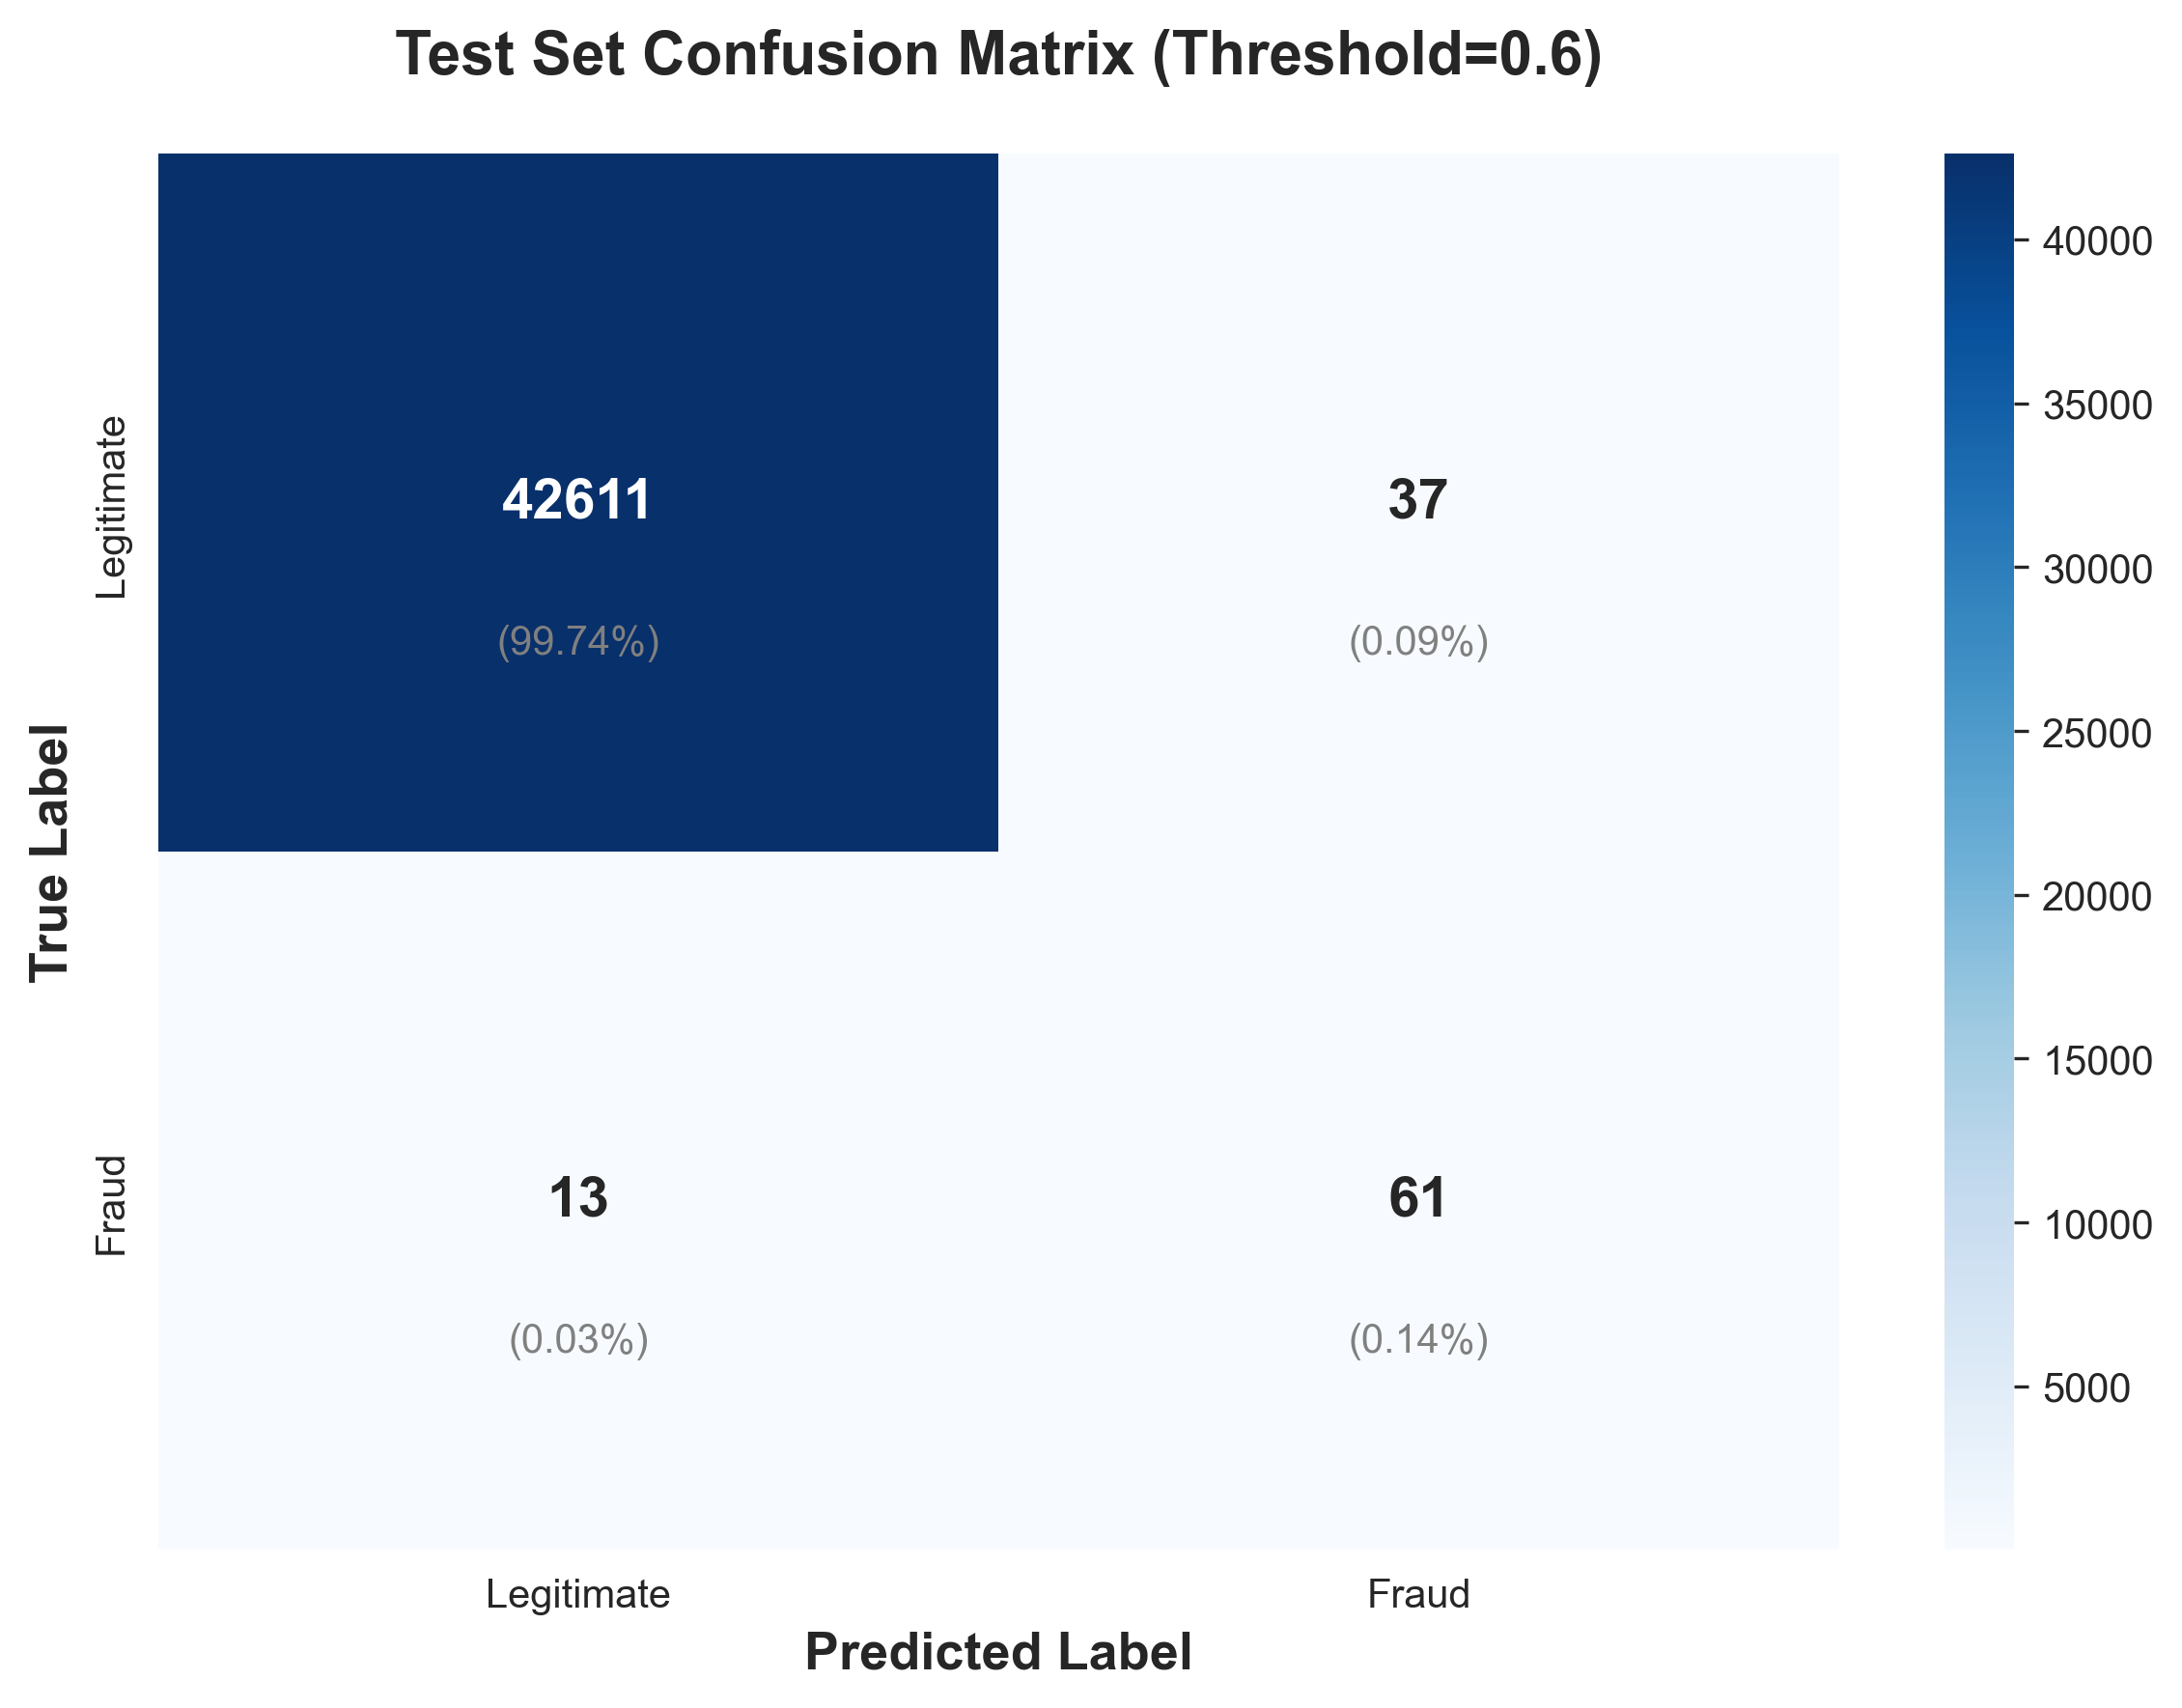

✓ Confusion matrix saved to: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\figures\final_test_confusion_matrix.png


In [18]:
# Plot confusion matrix
fig_path = ds_config['figures_dir'] / 'final_test_confusion_matrix.png'
fig_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
plot_confusion_matrix(
    y_test,
    y_test_pred,
    labels=['Legitimate', 'Fraud'],
    save_path=str(fig_path),
    title=f'Test Set Confusion Matrix (Threshold={best_threshold})'
)
print(f"✓ Confusion matrix saved to: {fig_path}")

## 7. Precision-Recall Curve

PR curve saved to c:\Users\GOD\Documents\NNfinalProject\results\creditcard\figures\final_test_pr_curve.png


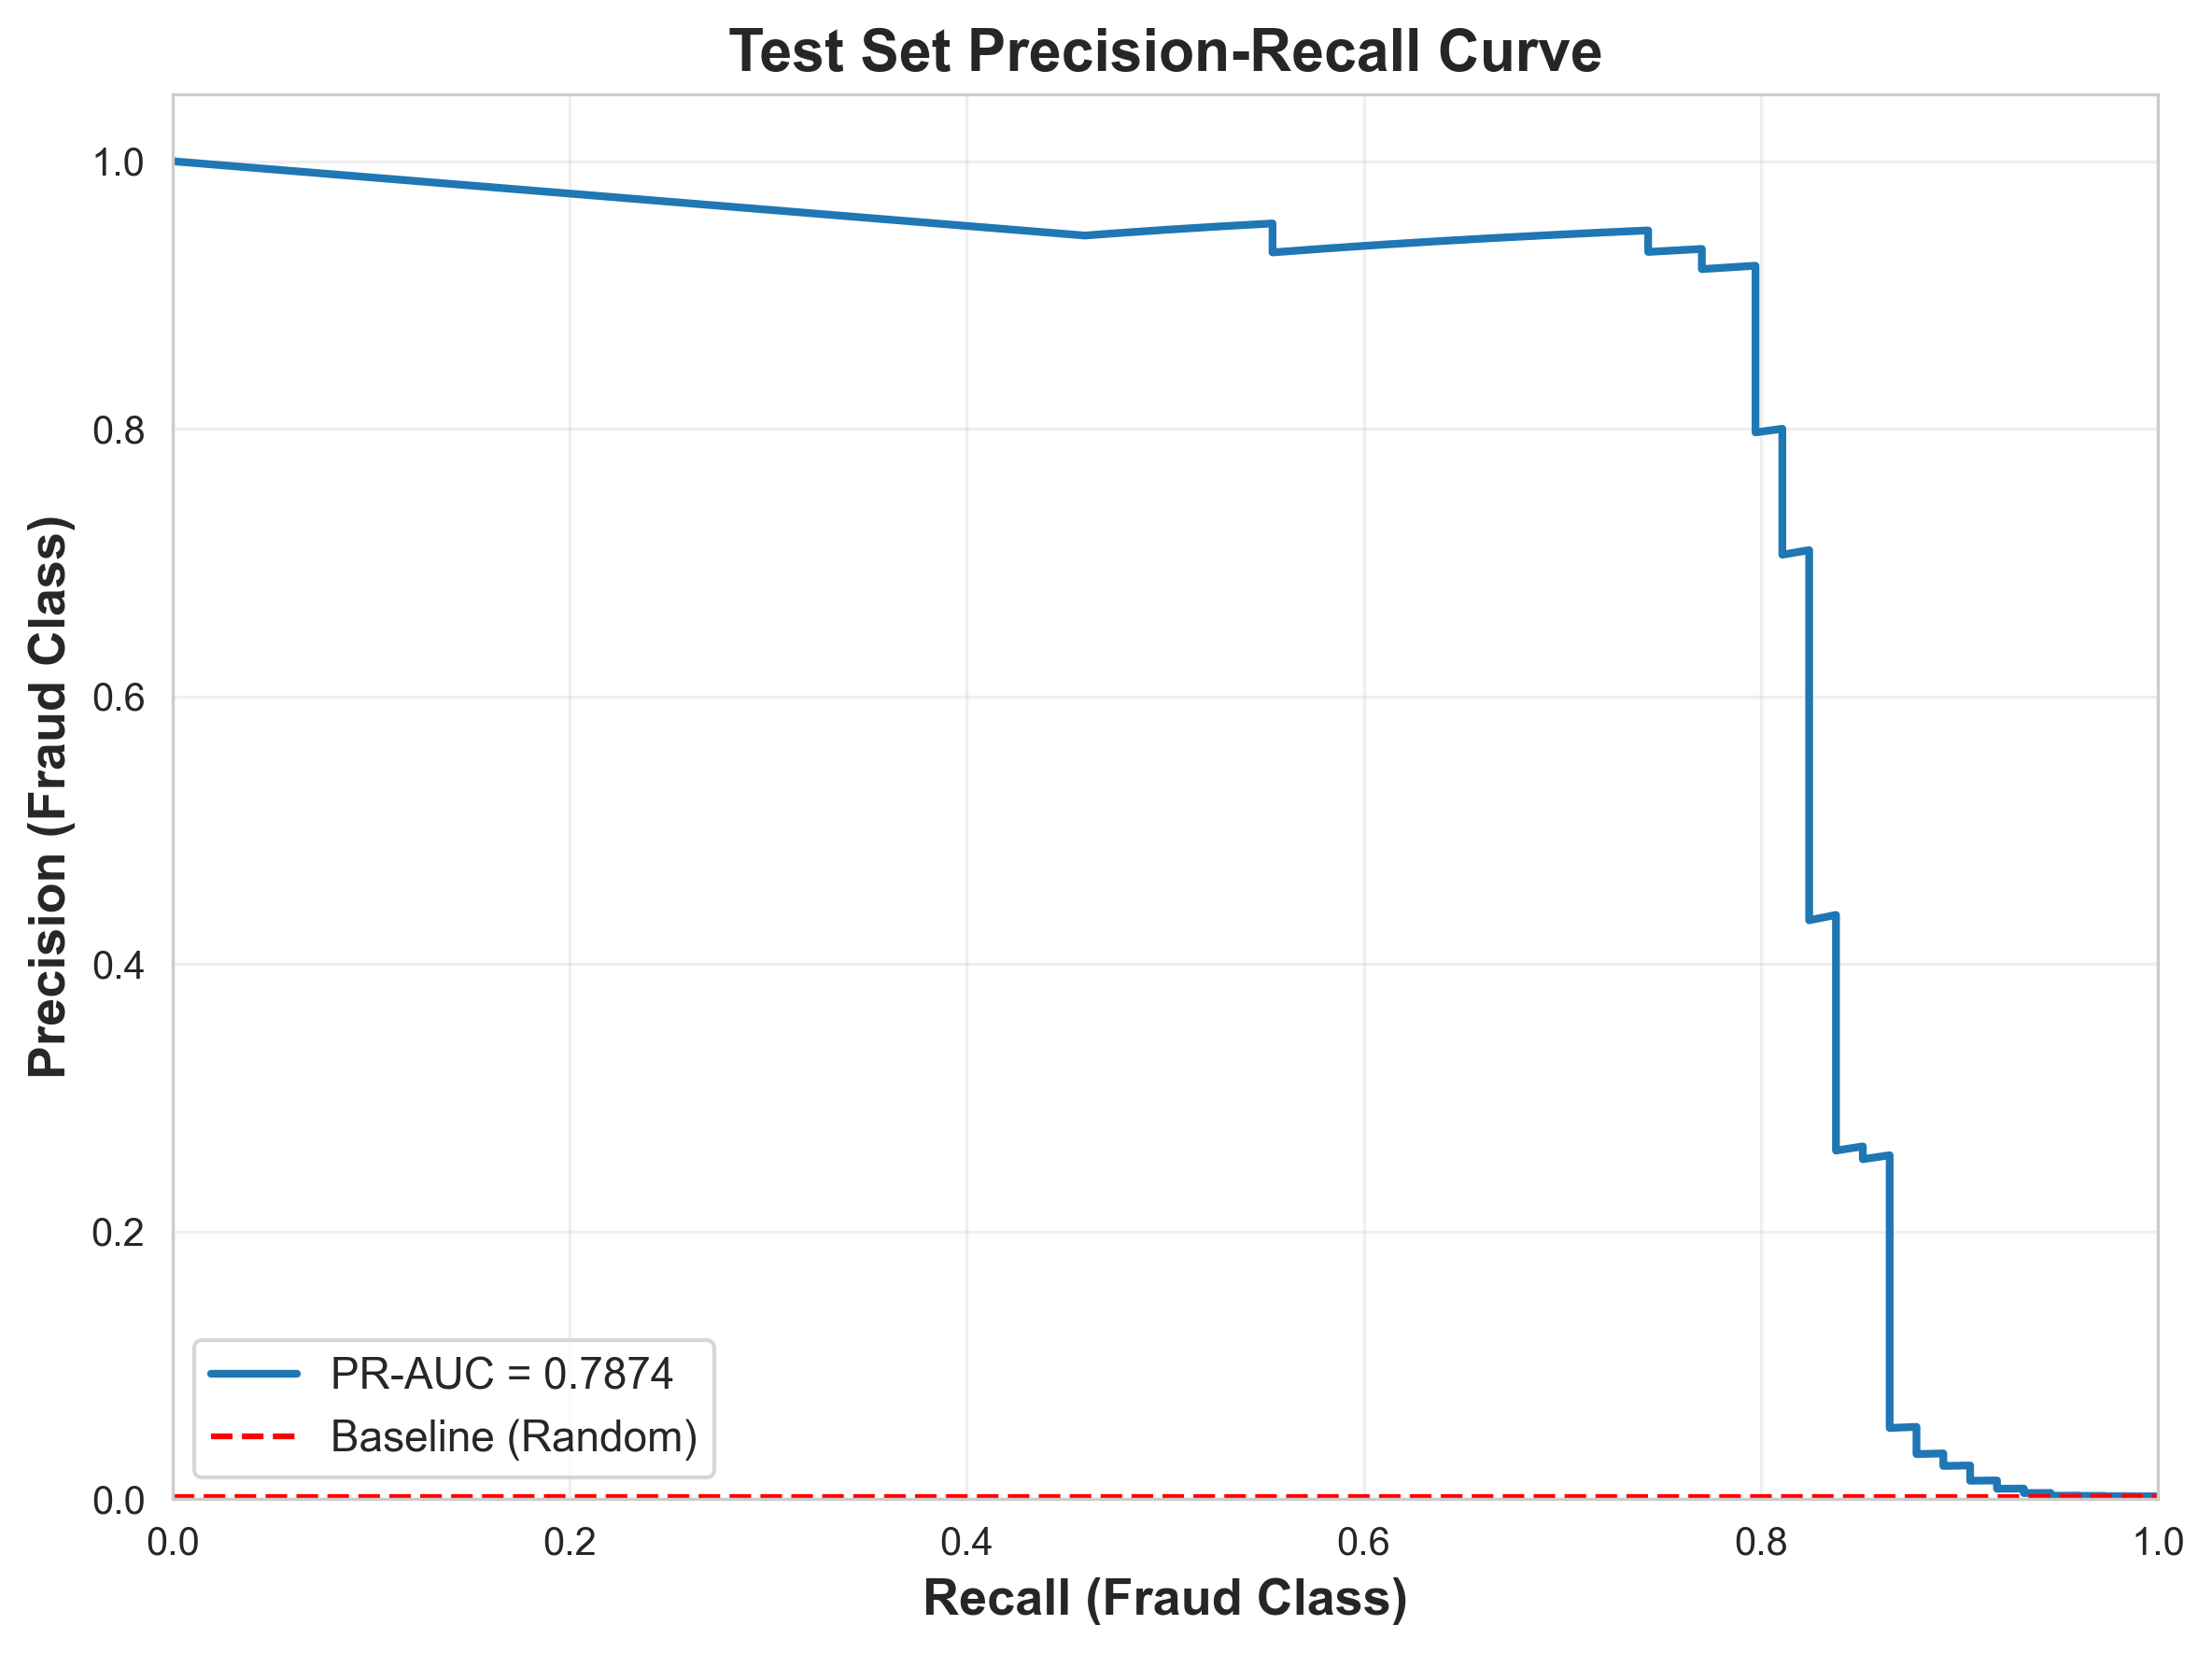

✓ PR curve saved to: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\figures\final_test_pr_curve.png


In [19]:
# Plot PR curve
fig_path = ds_config['figures_dir'] / 'final_test_pr_curve.png'
fig_path.parent.mkdir(parents=True, exist_ok=True)  # Ensure directory exists
plot_precision_recall_curve(
    y_test,
    y_test_pred_proba,
    save_path=str(fig_path),
    title='Test Set Precision-Recall Curve'
)
print(f"✓ PR curve saved to: {fig_path}")

## 8. Error Analysis

Analyze false positives and false negatives to understand model failure modes.

In [20]:
# Identify error cases
false_positives = (y_test == 0) & (y_test_pred == 1)
false_negatives = (y_test == 1) & (y_test_pred == 0)
true_positives = (y_test == 1) & (y_test_pred == 1)
true_negatives = (y_test == 0) & (y_test_pred == 0)

print("\n" + "="*80)
print(" ERROR ANALYSIS")
print("="*80)
print(f"\nFalse Positives: {false_positives.sum():,} ({false_positives.sum()/len(y_test)*100:.2f}%)")
print(f"False Negatives: {false_negatives.sum():,} ({false_negatives.sum()/len(y_test)*100:.2f}%)")
print(f"True Positives:  {true_positives.sum():,} ({true_positives.sum()/len(y_test)*100:.2f}%)")
print(f"True Negatives:  {true_negatives.sum():,} ({true_negatives.sum()/len(y_test)*100:.2f}%)")

# Analyze prediction confidence for errors
print(f"\n📊 Prediction Confidence Analysis:")
print(f"\nFalse Positives (predicted fraud incorrectly):")
print(f"  Mean confidence: {y_test_pred_proba[false_positives].mean():.4f}")
print(f"  Median confidence: {np.median(y_test_pred_proba[false_positives]):.4f}")
print(f"  Min confidence: {y_test_pred_proba[false_positives].min():.4f}")
print(f"  Max confidence: {y_test_pred_proba[false_positives].max():.4f}")

print(f"\nFalse Negatives (missed fraud):")
print(f"  Mean confidence: {y_test_pred_proba[false_negatives].mean():.4f}")
print(f"  Median confidence: {np.median(y_test_pred_proba[false_negatives]):.4f}")
print(f"  Min confidence: {y_test_pred_proba[false_negatives].min():.4f}")
print(f"  Max confidence: {y_test_pred_proba[false_negatives].max():.4f}")

print(f"\nTrue Positives (correctly detected fraud):")
print(f"  Mean confidence: {y_test_pred_proba[true_positives].mean():.4f}")
print(f"  Median confidence: {np.median(y_test_pred_proba[true_positives]):.4f}")
print(f"  Min confidence: {y_test_pred_proba[true_positives].min():.4f}")
print(f"  Max confidence: {y_test_pred_proba[true_positives].max():.4f}")
print("="*80)


 ERROR ANALYSIS

False Positives: 37 (0.09%)
False Negatives: 13 (0.03%)
True Positives:  61 (0.14%)
True Negatives:  42,611 (99.74%)

📊 Prediction Confidence Analysis:

False Positives (predicted fraud incorrectly):
  Mean confidence: 0.8651
  Median confidence: 0.8975
  Min confidence: 0.6126
  Max confidence: 1.0000

False Negatives (missed fraud):
  Mean confidence: 0.0311
  Median confidence: 0.0001
  Min confidence: 0.0000
  Max confidence: 0.2564

True Positives (correctly detected fraud):
  Mean confidence: 0.9959
  Median confidence: 1.0000
  Min confidence: 0.7982
  Max confidence: 1.0000


## 9. Business Cost Analysis

Simulate business costs assuming:
- False Positive cost: Manual review ($25 per transaction)
- False Negative cost: Fraud loss ($100 per transaction)
- True Positive benefit: Fraud prevented ($100 per transaction)

In [21]:
# Define cost parameters
COST_FP = 25    # Manual review cost
COST_FN = 100   # Fraud loss
BENEFIT_TP = 100  # Fraud prevented

# Calculate costs
total_fp_cost = test_metrics['false_positives'] * COST_FP
total_fn_cost = test_metrics['false_negatives'] * COST_FN
total_tp_benefit = test_metrics['true_positives'] * BENEFIT_TP

net_benefit = total_tp_benefit - total_fp_cost - total_fn_cost

# Calculate cost if we did nothing (all fraud passes through)
do_nothing_cost = y_test.sum() * COST_FN

# Calculate savings
savings = do_nothing_cost - total_fn_cost - total_fp_cost
savings_rate = (savings / do_nothing_cost) * 100

print("\n" + "="*80)
print(" BUSINESS COST ANALYSIS")
print("="*80)
print(f"\nCost Assumptions:")
print(f"  False Positive: ${COST_FP} (manual review)")
print(f"  False Negative: ${COST_FN} (fraud loss)")
print(f"  True Positive:  ${BENEFIT_TP} (fraud prevented)")

print(f"\nModel Performance:")
print(f"  False Positives: {test_metrics['false_positives']:,} → Cost: ${total_fp_cost:,.2f}")
print(f"  False Negatives: {test_metrics['false_negatives']:,} → Cost: ${total_fn_cost:,.2f}")
print(f"  True Positives:  {test_metrics['true_positives']:,} → Benefit: ${total_tp_benefit:,.2f}")

print(f"\nNet Analysis:")
print(f"  Total Cost:         ${(total_fp_cost + total_fn_cost):,.2f}")
print(f"  Total Benefit:      ${total_tp_benefit:,.2f}")
print(f"  Net Benefit:        ${net_benefit:,.2f}")

print(f"\nComparison to Baseline (No Model):")
print(f"  Do-Nothing Cost:    ${do_nothing_cost:,.2f}")
print(f"  Model Cost:         ${(total_fp_cost + total_fn_cost):,.2f}")
print(f"  Savings:            ${savings:,.2f} ({savings_rate:.1f}% reduction)")
print("="*80)

# Save business analysis
business_analysis = {
    'model_id': best_exp_id,
    'threshold': best_threshold,
    'cost_fp': COST_FP,
    'cost_fn': COST_FN,
    'benefit_tp': BENEFIT_TP,
    'total_fp_cost': total_fp_cost,
    'total_fn_cost': total_fn_cost,
    'total_tp_benefit': total_tp_benefit,
    'net_benefit': net_benefit,
    'do_nothing_cost': do_nothing_cost,
    'savings': savings,
    'savings_rate_percent': savings_rate
}

business_df = pd.DataFrame([business_analysis])
business_path = ds_config['tables_dir'] / 'business_cost_analysis.csv'
business_df.to_csv(business_path, index=False)
print(f"\n✓ Business analysis saved to: {business_path}")


 BUSINESS COST ANALYSIS

Cost Assumptions:
  False Positive: $25 (manual review)
  False Negative: $100 (fraud loss)
  True Positive:  $100 (fraud prevented)

Model Performance:
  False Positives: 37 → Cost: $925.00
  False Negatives: 13 → Cost: $1,300.00
  True Positives:  61 → Benefit: $6,100.00

Net Analysis:
  Total Cost:         $2,225.00
  Total Benefit:      $6,100.00
  Net Benefit:        $3,875.00

Comparison to Baseline (No Model):
  Do-Nothing Cost:    $7,400.00
  Model Cost:         $2,225.00
  Savings:            $5,175.00 (69.9% reduction)

✓ Business analysis saved to: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\tables\business_cost_analysis.csv


## 10. Summary & Final Recommendations

In [23]:
print("\n" + "="*80)
print(" NOTEBOOK 06 SUMMARY - FINAL TEST EVALUATION")
print("="*80)

print(f"\n🏆 Best Model: {best_exp_id}")
print(f"   Optimal Threshold: {best_threshold}")

print(f"\n📊 Test Set Performance:")
print(f"   PR-AUC:        {test_metrics['pr_auc']:.4f}")
print(f"   ROC-AUC:       {test_metrics['roc_auc']:.4f}")
print(f"   F1 (Fraud):    {test_metrics['f1_fraud']:.4f}")
print(f"   Recall (Fraud): {test_metrics['recall_fraud']:.4f}")
print(f"   Precision (Fraud): {test_metrics['precision_fraud']:.4f}")

print(f"\n💰 Business Impact:")
print(f"   Cost Savings:  ${savings:,.2f} ({savings_rate:.1f}% reduction)")
print(f"   Net Benefit:   ${net_benefit:,.2f}")

print(f"\n⚠️ Error Analysis:")
print(f"   False Positives: {test_metrics['false_positives']:,} (over-flagging legitimate)")
print(f"   False Negatives: {test_metrics['false_negatives']:,} (missed fraud)")

print(f"\n✅ Model Readiness:")
if test_metrics['pr_auc'] >= 0.75 and test_metrics['recall_fraud'] >= 0.70:
    print("   Status: READY FOR PRODUCTION")
    print("   Recommendation: Deploy with real-time monitoring")
elif test_metrics['pr_auc'] >= 0.65 and test_metrics['recall_fraud'] >= 0.60:
    print("   Status: ACCEPTABLE WITH MONITORING")
    print("   Recommendation: Deploy with enhanced fraud analyst support")
else:
    print("   Status: NEEDS IMPROVEMENT")
    print("   Recommendation: Further tuning or additional features required")

print(f"\n🚀 Next Steps:")
print("   1. Cross-dataset analysis (Notebook 07)")
print("   2. Compare generalization across datasets")
print("   3. Identify transferable design principles")
print("   4. Document final findings and limitations")

print(f"\n📁 Artifacts Created:")
print(f"   - Threshold optimization: {ds_config['tables_dir']}/threshold_optimization.csv")
print(f"   - Test evaluation: {ds_config['tables_dir']}/final_test_evaluation.csv")
print(f"   - Business analysis: {ds_config['tables_dir']}/business_cost_analysis.csv")
print(f"   - Confusion matrix: {ds_config['figures_dir']}/final_test_confusion_matrix.png")
print(f"   - PR curve: {ds_config['figures_dir']}/final_test_pr_curve.png")

print("\n✅ Notebook 06 Complete!")
print("🎯 Ready for Notebook 07: Cross-dataset analysis and conclusions")
print("="*80)


 NOTEBOOK 06 SUMMARY - FINAL TEST EVALUATION

🏆 Best Model: REG-07
   Optimal Threshold: 0.6

📊 Test Set Performance:
   PR-AUC:        0.7874
   ROC-AUC:       0.9483
   F1 (Fraud):    0.7093
   Recall (Fraud): 0.8243
   Precision (Fraud): 0.6224

💰 Business Impact:
   Cost Savings:  $5,175.00 (69.9% reduction)
   Net Benefit:   $3,875.00

⚠️ Error Analysis:
   False Positives: 37 (over-flagging legitimate)
   False Negatives: 13 (missed fraud)

✅ Model Readiness:
   Status: READY FOR PRODUCTION
   Recommendation: Deploy with real-time monitoring

🚀 Next Steps:
   1. Cross-dataset analysis (Notebook 07)
   2. Compare generalization across datasets
   3. Identify transferable design principles
   4. Document final findings and limitations

📁 Artifacts Created:
   - Threshold optimization: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\tables/threshold_optimization.csv
   - Test evaluation: c:\Users\GOD\Documents\NNfinalProject\results\creditcard\tables/final_test_evaluation.